# Data Reading and Imputation

## Data used Biospecimen. ('ABeta 1-42','Abeta 42', 'tTau', 'CSF Alpha-synuclein', 'Total tau')

### imputations were done for each visit seperately
### values which could not be imputed were removed
### dimensionof data after imputation (1294, 7)
####  values like >1700, <200, <80 was replaced by 2000, 100 and 40 resp.

In [2]:

from sklearn import preprocessing
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline


cols = {} 
cols["biospecimen"] = ["PATNO", "CLINICAL_EVENT","TYPE", "TESTNAME", "TESTVALUE", "UNITS"]
biospecimen = pd.read_csv("~/health data/project 1/data/Biospecimen_Analysis_Results.csv", index_col=["PATNO"], usecols=cols["biospecimen"])
biospecimen["CLINICAL_EVENT"].replace(['Baseline Collection', 'Screening Visit', 'Visit 01', 'Visit 02', 'Visit 03', 'Visit 04', 'Visit 05', 'Visit 06', 'Visit 07', 'Visit 08', 'Visit 09', 'Visit 10', 'Visit 11'],                             ['BL', 'SC', 'V01', 'V02', 'V03', 'V04', 'V06', 'V07', 'V08', 'V09', 'V10', 'V11', 'V12'], inplace=True)
biospecimen.rename(columns={'CLINICAL_EVENT':'EVENT_ID'}, inplace=True)
M_label_PD_HC = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\project 1\\random data/M_label_PD_HC.csv", index_col = ['PATNO'])
M_cat = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\project 1\\random data/M_cat.csv", index_col = ['PATNO'])
M_W = pd.read_csv("C:\\Users\\Vipul Satone\\health data\\project 1\\random data/M_W.csv", index_col = ['PATNO'])


from sklearn import preprocessing

serum1 = biospecimen[["EVENT_ID", "TESTNAME", "TESTVALUE"]]
a1 = pd.DataFrame(serum1.reset_index().set_index(['PATNO', "EVENT_ID", "TESTNAME"])\
                 .sort_index(level='PATNO'))
a = a1[~a1.index.duplicated()].unstack().reset_index().set_index(['PATNO'])


a.rename(columns={('EVENT_ID',''): 'EVENT_ID'}, inplace=True)
a = a[a.EVENT_ID.isin(['BL','V02','V04','V06'])]

aq = list(a.columns)
for i in range(len(aq)):
    aq[i] = aq[i][1]
    
aq[0] = 'V'
a.columns= aq

a1 = a.T
a1 = a1[a1.index.isin(['ABeta 1-42','Abeta 42','tTau', 'CSF Alpha-synuclein', 'Total tau','V','GMM'])]
#asde = list(a.columns)
a = a1.T
a = a.merge(M_label_PD_HC,left_index=True,right_index=True, how='outer')

filt = list(a.GMM.unique()) 
del filt[3]
a= a[a.GMM.isin(filt)]
a.shape


a.iloc[:,1] = a.iloc[:,1].replace(['>1700','<200'] , [1700, 200])
a.iloc[:,5] = a.iloc[:,5].replace(['<80',] , [80])
for i in range(a.shape[1]):
    try:
        a.iloc[:,i] = a.iloc[:,i].astype('float64', errors = 'ignore')
        #a.iloc[:,i] = pd.DataFrame(a.iloc[:,i]).interpolate(method='linear', axis=0, limit_direction = 'both')
        
    except:
        pass
    
visit_list = ['BL','V02','V04','V06']
for i in range(len(visit_list)):
    a[a.V == visit_list[i]] = pd.DataFrame(a[a.V == visit_list[i]] ).interpolate(method='linear', axis=0, limit_direction = 'both')

#a = pd.DataFrame(a).interpolate(method='linear', axis=0, limit_direction = 'both')
a = a[~(a.isnull().sum(axis = 1) >= 2)]
a.isnull().sum()
a.isnull().sum(axis = 1).sum()

a.iloc[:,1:-1] = preprocessing.normalize(a.iloc[:,1:-1], axis = 0)

a['Abeta_42_by_tau'] = a["Abeta 42"]/a['Total tau']
a['Abeta_142_by_tau'] = a["ABeta 1-42"]/a['Total tau']


## Using NMF , ICA and PCA to visualize any pattern in data

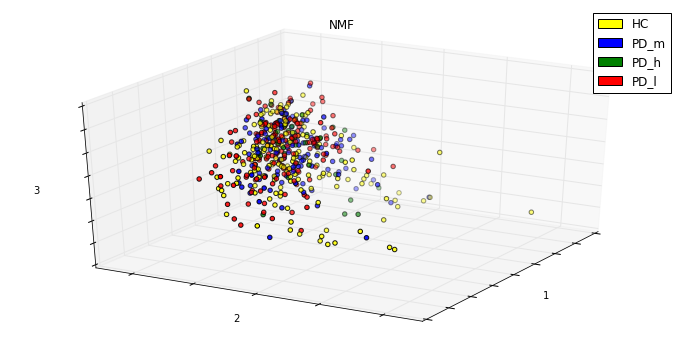

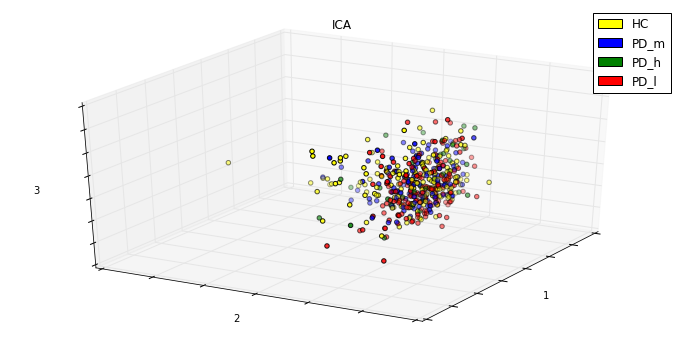

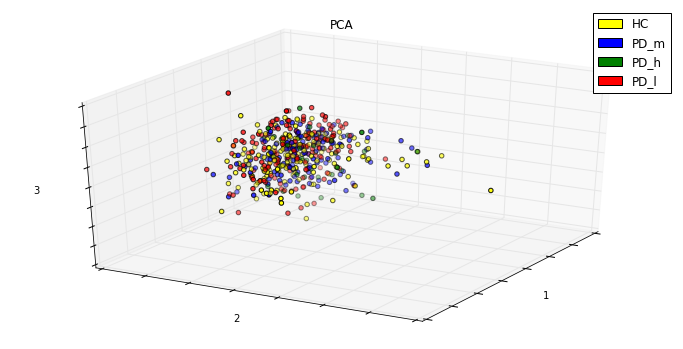

In [4]:

# read M_chosen
a_org= a
a1 = a.reset_index().set_index(['PATNO','V']).unstack()
#a1_label =a1.iloc[:,( (a1.columns.get_level_values(1) == 'BL') & (a1.columns.get_level_values(0) == 'GMM') )]
a1 =a1.iloc[ :,~(a1.columns.get_level_values(0) == 'GMM') ]
a2 = a[~a.index.duplicated()]
a1_label = a2.GMM
for i in range(a1.shape[1]):
    a1.iloc[:,i] = pd.DataFrame(a1.iloc[:,i] ).interpolate(method='linear', axis=0, limit_direction = 'both')

a1 = pd.DataFrame(a1).sort_index(ascending=False)
for i in range(a1.shape[1]):
    a1.iloc[:,i] = pd.DataFrame(a1.iloc[:,i] ).interpolate(method='linear', axis=0, limit_direction = 'both')

a1.isnull().sum()
a1.isnull().sum(axis = 1).sum()
a1 = np.asarray(pd.DataFrame(a1).sort_index(ascending=True))
for i in range((a1.shape[1])):
    a1[:,i] = (a1[:,i] - a1[:,i].min().min()) / ( a1[:,i].max().max() - a1[:,i].min() )

# NMF
from sklearn import decomposition
model_NMF3 = decomposition.NMF(n_components=3, init='nndsvda', max_iter=200)
a_new = pd.DataFrame( model_NMF3.fit_transform(a1) )

# ICA
model_ICA = decomposition.FastICA(n_components=3)
a_new2 = model_ICA.fit_transform(a1)

a_new2 = pd.DataFrame(a_new2)

# PCA
from sklearn.decomposition import PCA as sklearnPCA
model_pca = sklearnPCA(n_components=3)
a_new3 = model_pca.fit_transform(a1)

a_new3 = pd.DataFrame(a_new3)

t = {1 : a_new , 2: a_new2 , 3 : a_new3}
s = ['NMF' , 'ICA' , 'PCA']
%matplotlib inline
def featur_red_visu(a_ne, y):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(111, projection='3d')
    colors_categories = a1_label.iloc[:].replace(['PD_l' , 'PD_m' , 'PD_h' , 'HC'], ['red', 'blue', 'green', 'yellow'])

    pts = ax.scatter(a_ne.iloc[:,0] , a_ne.iloc[:,1], a_ne.iloc[:,2], c = colors_categories)

    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='yellow')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    plt.legend((p1, p2, p3, p4), ('HC' , 'PD_m' , 'PD_h' , 'PD_l'), loc='best',prop={'size':12});

    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xlabel('1')
    ax.set_ylabel('2')
    ax.set_zlabel('3')
    ax.set_title(s[y])
    ax.grid(True)
    ax.view_init(azim=30)
    plt.show()

for y in range(len(t)):
    featur_red_visu(t[y+1], y)

## There is no observable pattern in these projections visually 
#### Unsupervised clustering can be used to find /mine hidden pattern


## Visualizing distribution of 'ABeta 1-42','Abeta 42', 'tTau', 'CSF Alpha-synuclein', 'Total tau' in cognitive, sleep and motor feature space.

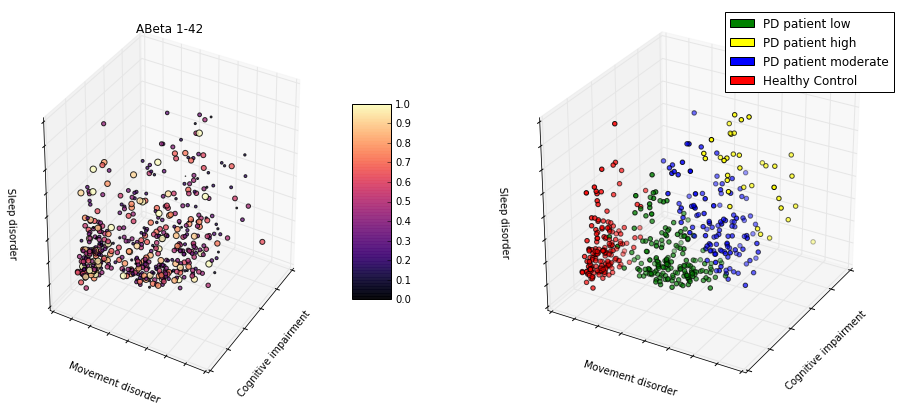

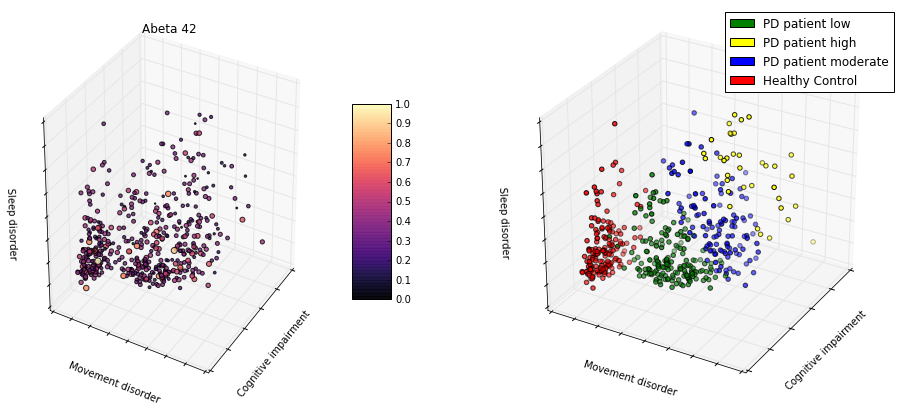

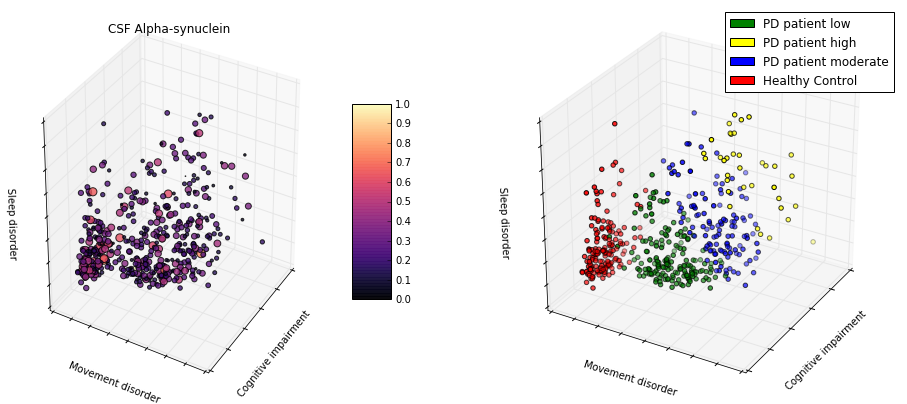

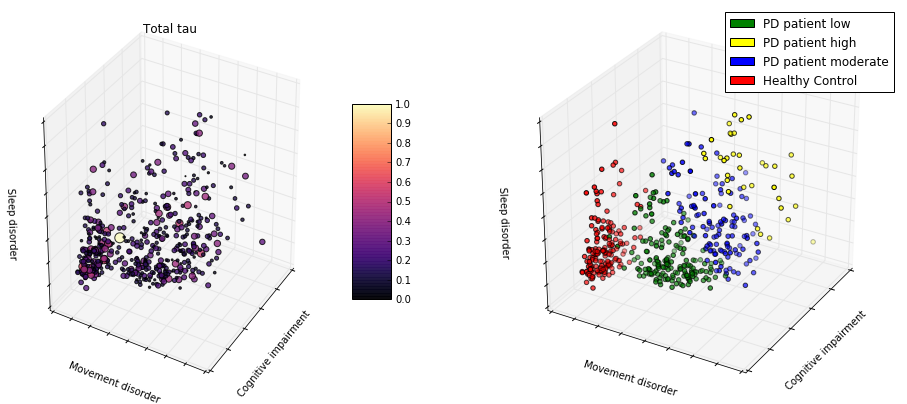

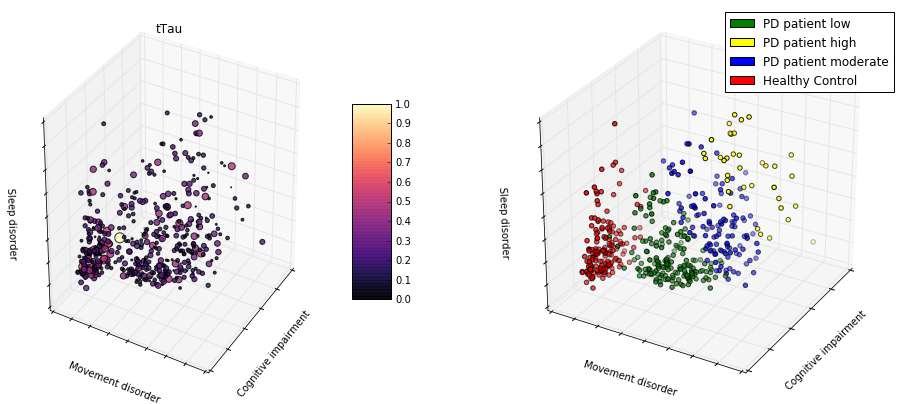

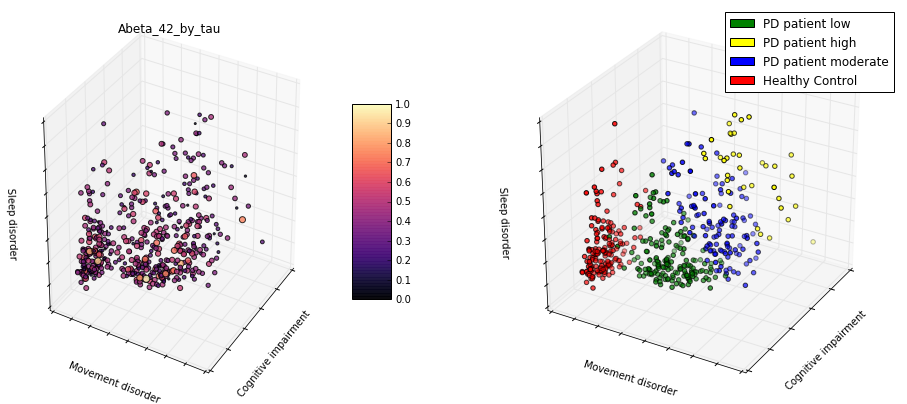

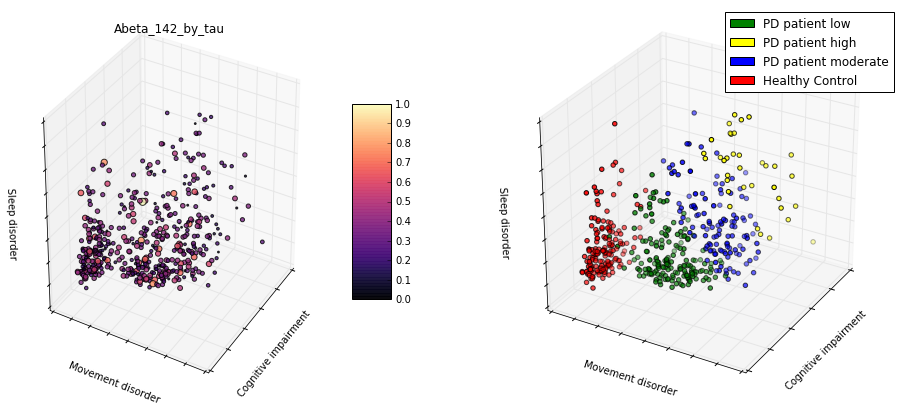

In [8]:
M_W_PD_HC = M_W.loc[ M_cat.ENROLL_CAT.isin(['HC', 'PD']) ]
a_org = a_org[(a_org.V == 'BL')]
a_org = a_org[(a_org.index.isin(M_W_PD_HC.index))]
M_W_PD_HC = M_W_PD_HC[(M_W_PD_HC.index.isin(a_org.index))]

for i in range((a_org.shape[1])):
    try:
        a_org.iloc[:,i] = (a_org.iloc[:,i] - a_org.iloc[:,i].min().min()) / ( a_org.iloc[:,i].max().max() - a_org.iloc[:,i].min() )
        #print(i)
    except:
        pass
      
M_label_PD_HC = M_label_PD_HC[ M_label_PD_HC.index.isin(a_org.index)]
ser_list = a_org.columns.tolist()[0:1] + a_org.columns.tolist()[1:6] + a_org.columns.tolist()[7:] + a_org.columns.tolist()[6:7]
a_org = a_org[ser_list]
mag_list = [40, 40, 100, 100, 100,50,50]
l_str = ['magma', 'magma', 'magma', 'magma', 'magma', 'magma', 'magma']
def visual(i):
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(16, 7))
    ax = fig.add_subplot(121, projection='3d')
    pts = ax.scatter(M_W_PD_HC[['NMF_3_1']], M_W_PD_HC[['NMF_3_2']], M_W_PD_HC[['NMF_3_3']], c = a_org.iloc[:,i] , alpha = 0.8, s = a_org.iloc[:,i]*mag_list[i-1], cmap = l_str[i-1] )
    fig.colorbar(pts, shrink=0.5, aspect=5)
    '''s = a_org.iloc[:,1]*100,'''

    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xlabel('Cognitive impairment')
    ax.set_ylabel('Movement disorder')
    ax.set_zlabel('Sleep disorder')
    ax.set_title(ser_list[i])
    # Set rotation angle to 30 degrees
    ax.view_init(azim=30)



    ax = fig.add_subplot(122, projection='3d')

    ax.scatter(M_W_PD_HC[['NMF_3_1']], M_W_PD_HC[['NMF_3_2']], M_W_PD_HC[['NMF_3_3']], c = M_label_PD_HC.iloc[:,-1].replace(['HC','PD_l', 'PD_m', 'PD_h'], ['red','green','blue','yellow']))

    p1 = plt.Rectangle((0, 0), 0.1, 0.1, fc='red')
    p2 = plt.Rectangle((0, 0), 0.1, 0.1, fc='blue')
    p3 = plt.Rectangle((0, 0), 0.1, 0.1, fc='green')
    p4 = plt.Rectangle((0, 0), 0.1, 0.1, fc='yellow')
    
    plt.legend((p3, p4,p2,p1), ('PD patient low','PD patient high', 'PD patient moderate' ,'Healthy Control' ), loc='best');

    ax.grid(True)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xlabel('Cognitive impairment')
    ax.set_ylabel('Movement disorder')
    ax.set_zlabel('Sleep disorder')

    # Set rotation angle to 30 degrees
    ax.view_init(azim=30)

    plt.show()
    


for u in range(len(ser_list)-2):
    visual(u+1)


### No observable pattern if found in above graphs. Even in last visualiation, when quantities of the protein in blood was visualized with respect to visits nothing substantial was found.
#### So I am applying unsupervised clustering to get some of the. 
#### Currently, above data includes the proteins from biospecimen which was suggested by you. I am trying to include more of them to find some realation (But, as the data is incomplete the more features I include the more comprimise I have to make on quality of the data)